In [1]:
!pip install deslib

     |████████████████████████████████| 163kB 5.5MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from collections import Counter

from scipy.io import arff
import urllib.request
import io

import operator
from functools import partial
from deslib.util.instance_hardness import kdn_score

from sklearn.linear_model import Perceptron
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV

from deslib.dcs import OLA, LCA, MCB
from deslib.des import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.static import (StackedClassifier,SingleBest,StaticSelection)

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

load dataset .. 

Dois bancos de dados binários e com atributos numéricos do [repositório Promise](http://promise.site.uottawa.ca/SERepository/datasets-page.html).

In [4]:
def load_data(full_filepath, url=False): 
	if url:
		ftpstream = urllib.request.urlopen(full_filepath)
		data, _ = arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))
	else: 
		data, _ = arff.loadarff(full_filepath) 

	df = pd.DataFrame(data)
	df.dropna(inplace=True)
	df[df.columns[-1]] = df.apply(lambda x:  x[df.columns[-1]].decode(), axis=1)
		
	labels = pd.DataFrame(df[df.columns[-1]])
	instances = df.drop([df.columns[-1]], axis=1)
   
  # pre-processing 
	print('Original dataset shape %s' % labels.value_counts())
	sm = SMOTE(random_state=42)
	instances, labels = sm.fit_resample(instances, labels)
	print('Resampled dataset shape %s' % Counter(labels)) 
	instances = pd.DataFrame(preprocessing.scale(instances))
  #replace labels 
	labels = pd.DataFrame(labels)
	labels = labels.replace(["false", "true"],[0,1])  
	return instances,labels

In [5]:
cm1 = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/Exercicio-3/data/cm1.arff"
kc1 = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/Exercicio-3/data/kc1.arff"
datasets_filenames = [cm1, kc1]
datasets_names = ['cm1','kc1']

instances ={}
labels = {}

print("load data")
for name, file_name in zip(datasets_names, datasets_filenames):
  print(name)
  instances[name], labels[name] = load_data(file_name, url=True)

load data
cm1
Original dataset shape defects
false      449
true        49
dtype: int64
Resampled dataset shape Counter({'false': 449, 'true': 449})
kc1
Original dataset shape defects
false      1783
true        326
dtype: int64
Resampled dataset shape Counter({'false': 1783, 'true': 1783})


Suponha três variantes do conjunto de validação:

(a) o conjunto original 𝒱; 

(b) o conjunto 𝒱’ contendo apenas as instâncias difíceis (kDN > 0,5) de 𝒱;

(c) o conjunto 𝒱’ contendo apenas as instâncias fáceis (kDN <= 0,5) de 𝒱.

In [6]:
threshold = 0.5

kdn_conf = [("V_0", partial(operator.gt, 2)), ("V_1", partial(operator.lt, threshold)), ("V_2", partial(operator.gt, threshold))]

In [7]:
def _filter_based_hardness(instances, labels, hards, op):

  triples = [(instances[i], labels[i], hards[i]) for i in range(len(hards))]

  return filter(lambda t: op(t[2]), triples)

In [8]:
def select_val_set(instances, labels, kdn_config, k):
  
  kdn_scores, neighbors = kdn_score(instances,labels.flatten(), k)

  filtered = _filter_based_hardness(instances, labels, kdn_scores, kdn_config)

  X_val = []
  y_val = []

  for t in filtered:
    X_val.append(t[0])
    y_val.append(t[1])

  return np.array(X_val), np.array(y_val)

taxa de acerto, AUC, g-mean e f-measure

In [87]:
def get_metrics(method, X_test):
  y_predict = method.predict(X_test)
  y_score = method.predict_proba(X_test)[:, 1]

  df_result = pd.DataFrame(columns = ['taxa_acerto','AUC', 'gmean','fmeasure']) 
  new_row = {'taxa_acerto': accuracy_score(y_test,y_predict),
            'AUC': roc_auc_score(y_test,y_score),
            'gmean': geometric_mean_score(y_test,y_predict),
            'fmeasure': f1_score(y_test,y_predict)}
  df_result = df_result.append(new_row, ignore_index=True)
        
  return df_result

In [29]:
def average_metrics(datasets_names, methods, n_folds, metrics):
  df_result_avg = pd.DataFrame(columns = ['dataset','KDN','metodo','taxa_acerto_mean','taxa_acerto_std','taxa_acerto','AUC', 'gmean','fmeasure']) 
  taxa_acerto,auc,gmean,fmeasure = [],[],[],[]
  for ds_name in datasets_names:
    for method in methods:
      for hardness_type, filter_func in kdn_conf:      
        for fold in range(1,n_folds+1):
          data = metrics_results[ds_name][fold][hardness_type][method]
          taxa_acerto.append(data.taxa_acerto[0])
          auc.append(data.AUC[0])
          gmean.append(data.gmean[0])
          fmeasure.append(data.fmeasure[0])
        new_row = {'dataset':ds_name,
                    'KDN': hardness_type,                   
                    'metodo':method,
                    'taxa_acerto_mean': np.mean(taxa_acerto),
                    'taxa_acerto_std': np.std(taxa_acerto),
                    'taxa_acerto': "%0.3f (%0.3f)" % (np.mean(taxa_acerto), np.std(taxa_acerto)),
                    'AUC': "%0.3f (%0.3f)" % (np.mean(auc), np.std(auc)),
                    'gmean': "%0.3f (%0.3f)" % (np.mean(gmean),np.std(gmean)),
                    'fmeasure': "%0.3f (%0.3f)" % (np.mean(fmeasure),np.std(fmeasure))}
        df_result_avg = df_result_avg.append(new_row, ignore_index=True)
  return df_result_avg       

K-fold

In [81]:
metrics_results = {}
n_folds = 10
rng = None
base_model = CalibratedClassifierCV(base_estimator = Perceptron(random_state=rng))

for ds_name in datasets_names: 
  print("Dataset name: ", ds_name)
  X = instances[ds_name]
  y = labels[ds_name]

  metrics_results[ds_name] = {}

  skf = StratifiedKFold(n_splits=n_folds,random_state=rng)
  # select 5 neighborns
  k = 5  

  # split the dataset into 7 folds to train, 2 to validation, and 1 to test
  val_size = 0.20

  for fold, division in enumerate(skf.split(X, y), 1):
    train_index, test_index = division[0], division[1] 

    train, valid = train_test_split(train_index, test_size=val_size)

    X_train, X_valid, X_test = X.iloc[train], X.iloc[valid], X.iloc[test_index]
    y_train, y_valid, y_test = y.iloc[train], y.iloc[valid], y.iloc[test_index]   

    metrics_results[ds_name][fold] = {}

    # Use the KDN to select the validation set
    for hardness_type, filter_func in kdn_conf:
      X_val, y_val = select_val_set(np.array(X_valid), np.array(y_valid), filter_func, k)      
      
      pool_classifiers = BaggingClassifier(base_estimator=base_model, n_estimators=100, random_state=rng)
      pool_classifiers.fit(X_train, y_train)

      # Métodos estáticos
      single_best = SingleBest(pool_classifiers)
      static_selection = StaticSelection(pool_classifiers)      

      #Inicialização das técnicas de seleção dinâmica (região de competência igual a 7)
      ola = OLA(pool_classifiers,k=7, random_state=rng)
      lca = LCA(pool_classifiers,k=7, random_state=rng)
      mcb = MCB(pool_classifiers,k=7, random_state=rng)

      knorau = KNORAU(pool_classifiers, k=7, random_state=rng)
      kne = KNORAE(pool_classifiers, k=7, random_state=rng)
      
      names = ['SB', 'SS',
               'OLA', 'LCA','MCB','KN-U', 'KN-E']
      
      methods = [single_best, static_selection,
                 ola, lca, mcb, knorau, kne]
      
      metrics_results[ds_name][fold][hardness_type] = {}

      for method, name in zip(methods, names):
        method.fit(X_val, y_val)
        metrics_results[ds_name][fold][hardness_type][name] = get_metrics(method, X_test)

Dataset name:  cm1
Dataset name:  kc1


In [82]:
df_result = average_metrics(datasets_names,names,n_folds,metrics_results)
df_result.to_csv("/content/df_result_avg.csv", index=False)
df_result.to_latex("/content/df_result_avg.tex",index=False)
df_result

,dataset,KDN,metodo,taxa_acerto_mean,taxa_acerto_std,taxa_acerto,AUC,gmean,fmeasure
0,cm1,V_0,SB,0.776217,0.066413,0.776 (0.066),0.843 (0.062),0.774 (0.066),0.775 (0.063)
1,cm1,V_1,SB,0.722179,0.098195,0.722 (0.098),0.813 (0.093),0.710 (0.108),0.704 (0.112)
2,cm1,V_2,SB,0.735019,0.088082,0.735 (0.088),0.818 (0.085),0.726 (0.097),0.725 (0.100)
3,cm1,V_0,SS,0.746723,0.084771,0.747 (0.085),0.827 (0.082),0.739 (0.092),0.738 (0.093)
4,cm1,V_1,SS,0.751523,0.082863,0.752 (0.083),0.833 (0.080),0.745 (0.089),0.741 (0.090)
5,cm1,V_2,SS,0.757876,0.080319,0.758 (0.080),0.837 (0.078),0.752 (0.086),0.748 (0.087)
6,cm1,V_0,OLA,0.764004,0.078476,0.764 (0.078),0.841 (0.076),0.758 (0.084),0.757 (0.085)
7,cm1,V_1,OLA,0.755777,0.077808,0.756 (0.078),0.836 (0.075),0.749 (0.084),0.744 (0.089)
8,cm1,V_2,OLA,0.758800,0.076850,0.759 (0.077),0.838 (0.073),0.752 (0.083),0.750 (0.087)
9,cm1,V_0,LCA,0.757538,0.074883,0.758 (0.075),0.837 (0.072),0.751 (0.080),0.750 (0.084)


In [88]:
def highlight_max(s):
  is_max = s == s.max()
  return ['font-weight: bold' if v else '' for v in is_max]

In [89]:
for ds_name in datasets_names:
    df = df_result
    df = df.drop('taxa_acerto_mean', axis=1)
    print("Dataset : ", ds_name)
    df = df.loc[(df_result['dataset'] == ds_name)]
    df = df.drop('dataset', axis=1)
    column_names = ['metodo','KDN','taxa_acerto','AUC','gmean','fmeasure']
    subset = ['taxa_acerto','AUC','gmean','fmeasure']
    df = df.reindex(columns=column_names) 
    df_data = df.reindex(columns=subset) 
    display(df_data.style.apply(highlight_max, axis=0).hide_index())
    df.to_latex(("/content/df_result_"+ ds_name + ".tex"), index = False, multirow = True, column_format='|c|c|l|l|l|l|')   

df_data


Dataset :  cm1


taxa_acerto,AUC,gmean,fmeasure
0.776 (0.066),0.843 (0.062),0.774 (0.066),0.775 (0.063)
0.722 (0.098),0.813 (0.093),0.710 (0.108),0.704 (0.112)
0.735 (0.088),0.818 (0.085),0.726 (0.097),0.725 (0.100)
0.747 (0.085),0.827 (0.082),0.739 (0.092),0.738 (0.093)
0.752 (0.083),0.833 (0.080),0.745 (0.089),0.741 (0.090)
0.758 (0.080),0.837 (0.078),0.752 (0.086),0.748 (0.087)
0.764 (0.078),0.841 (0.076),0.758 (0.084),0.757 (0.085)
0.756 (0.078),0.836 (0.075),0.749 (0.084),0.744 (0.089)
0.759 (0.077),0.838 (0.073),0.752 (0.083),0.750 (0.087)
0.758 (0.075),0.837 (0.072),0.751 (0.080),0.750 (0.084)


Dataset :  kc1


taxa_acerto,AUC,gmean,fmeasure
0.760 (0.075),0.838 (0.071),0.753 (0.081),0.752 (0.088)
0.756 (0.077),0.834 (0.072),0.748 (0.084),0.745 (0.093)
0.754 (0.076),0.832 (0.073),0.746 (0.084),0.744 (0.092)
0.753 (0.076),0.831 (0.073),0.745 (0.083),0.742 (0.091)
0.751 (0.076),0.830 (0.073),0.743 (0.083),0.740 (0.090)
0.750 (0.076),0.829 (0.072),0.742 (0.082),0.739 (0.089)
0.749 (0.075),0.828 (0.072),0.742 (0.082),0.738 (0.088)
0.746 (0.076),0.826 (0.073),0.738 (0.082),0.734 (0.090)
0.745 (0.076),0.825 (0.072),0.738 (0.082),0.734 (0.089)
0.744 (0.075),0.824 (0.072),0.736 (0.081),0.732 (0.088)


,taxa_acerto,AUC,gmean,fmeasure
21,0.760 (0.075),0.838 (0.071),0.753 (0.081),0.752 (0.088)
22,0.756 (0.077),0.834 (0.072),0.748 (0.084),0.745 (0.093)
23,0.754 (0.076),0.832 (0.073),0.746 (0.084),0.744 (0.092)
24,0.753 (0.076),0.831 (0.073),0.745 (0.083),0.742 (0.091)
25,0.751 (0.076),0.830 (0.073),0.743 (0.083),0.740 (0.090)
26,0.750 (0.076),0.829 (0.072),0.742 (0.082),0.739 (0.089)
27,0.749 (0.075),0.828 (0.072),0.742 (0.082),0.738 (0.088)
28,0.746 (0.076),0.826 (0.073),0.738 (0.082),0.734 (0.090)
29,0.745 (0.076),0.825 (0.072),0.738 (0.082),0.734 (0.089)
30,0.744 (0.075),0.824 (0.072),0.736 (0.081),0.732 (0.088)


**Plot gráficos**

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

Dataset :  cm1
/content/result_cm1.png


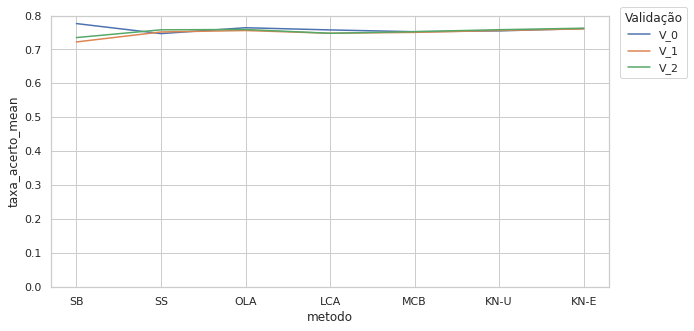

Dataset :  kc1
/content/result_kc1.png


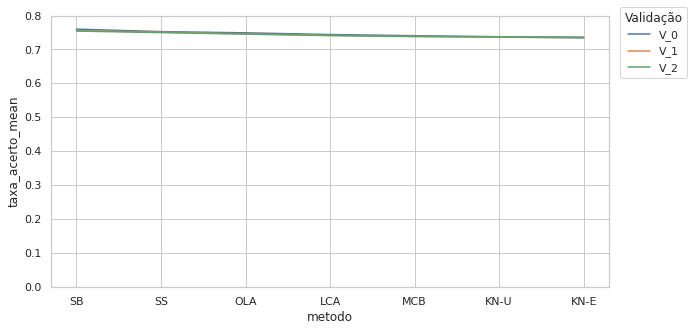

In [91]:
sns.set_theme(style="whitegrid")

for ds_name in datasets_names:
    print("Dataset : ", ds_name)
    df_data = df_result.loc[(df_result['dataset'] == ds_name)]
    fig = plt.figure(figsize=(10,5))     
    ax = sns.lineplot(x="metodo", y="taxa_acerto_mean",ci="taxa_acerto_std", err_style="bars", hue="KDN", data=df_data)
    plt.ylim(0.0, 0.8)
    ax.legend(loc='center right',bbox_to_anchor=(1.15, 0.9), ncol=1, title="Validação")
    file_name = '/content/result_' + str(ds_name) +'.png'
    print(file_name)
    fig.savefig(file_name)
    plt.show()
    

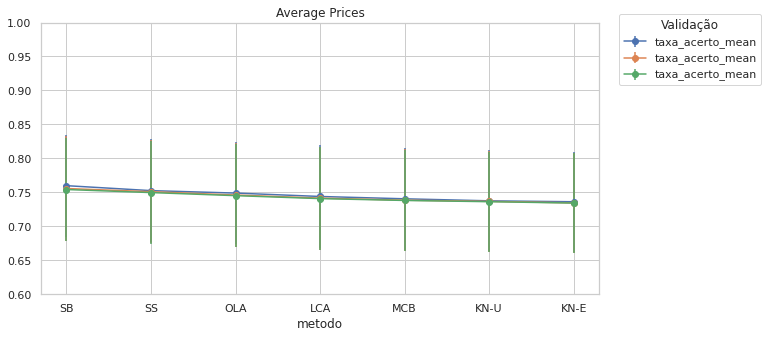

In [96]:
# Subplots as having two types of quality 
fig, ax = plt.subplots(figsize=(10,5)) 

for key, group in df_data.groupby('KDN'): 
    # group.plot('metodo', 'taxa_acerto_mean', yerr='taxa_acerto_std',  
    #            label=key, ax=ax) 
    ax = group.plot(kind = "line", x = "metodo", y = "taxa_acerto_mean", legend = True, 
            title = "Average Prices", yerr = "taxa_acerto_std", ax=ax, stacked=True, ylim=[0.6,1.0], fmt='-o')
    ax.legend(loc='center right',bbox_to_anchor=(1.3, 0.9), ncol=1, title="Validação") 
plt.show()

Análise estatística Kruskal

In [97]:
from scipy import stats

In [135]:
def get_est_result(p_array, names):
  result = []
  result2 = []
  x = 0
  # for x in range(len(names)-1):
  for y in range(x+1,len(names)):
    stat, pvalue = stats.kruskal(p_array[x], p_array[y])
    # print("Metodos: %s x %s" % (names[x], names[y]))
    # print("Estatística de kruskal: {:.3f} | P-value: {:.3}".format(stat, pvalue))
    #analisando resultados
    alpha = 0.05
    if pvalue < alpha:
      result.append([names[x], names[y]]) 
    else:
      result2.append([names[x], names[y]]) 
  print("Há diferença significativa entre o desempenho dos classificadores.")
  print(result)
  print("Não há diferença significativa entre o desempenho dos classificadores.")
  print(result2)

In [137]:
for ds_name in datasets_names:  
  data = []
  df = df.loc[(df_result['dataset'] == ds_name)]
  print("\n ------ " + ds_name + " ------ \n ")
  for hardness_type, filter_func in kdn_conf: 
    print(hardness_type)
    scores = [] 
    for method in names:           
      values = []      
      for fold in range(1,n_folds+1):         
        df_ = metrics_results[ds_name][fold][hardness_type][method]
        values.append(df_.taxa_acerto[0])
      scores.append(values)    
    pf = pd.DataFrame(np.transpose(scores))
    pf = pf.rename(columns = {0: 'SB', 1: 'SS', 2:'OLA', 3:'LCA', 4: 'MCB', 5:'KNU', 6:'KNE'}, inplace = False)
    p_array = pf.values
    get_est_result(p_array, names)  



 ------ cm1 ------ 
 
V_0
Há diferença significativa entre o desempenho dos classificadores.
[['SB', 'LCA'], ['SB', 'MCB'], ['SB', 'KN-U']]
Não há diferença significativa entre o desempenho dos classificadores.
[['SB', 'SS'], ['SB', 'OLA'], ['SB', 'KN-E']]
V_1
Há diferença significativa entre o desempenho dos classificadores.
[['SB', 'LCA'], ['SB', 'MCB'], ['SB', 'KN-E']]
Não há diferença significativa entre o desempenho dos classificadores.
[['SB', 'SS'], ['SB', 'OLA'], ['SB', 'KN-U']]
V_2
Há diferença significativa entre o desempenho dos classificadores.
[['SB', 'SS'], ['SB', 'MCB']]
Não há diferença significativa entre o desempenho dos classificadores.
[['SB', 'OLA'], ['SB', 'LCA'], ['SB', 'KN-U'], ['SB', 'KN-E']]

 ------ kc1 ------ 
 
V_0
Há diferença significativa entre o desempenho dos classificadores.
[['SB', 'SS'], ['SB', 'OLA'], ['SB', 'KN-U']]
Não há diferença significativa entre o desempenho dos classificadores.
[['SB', 'LCA'], ['SB', 'MCB'], ['SB', 'KN-E']]
V_1
Há diferen